In [1]:
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class ImageClassifier:
    def __init__(self, network, criterion, l2_lambda=0.01):
        self.network = network
        self.criterion = criterion
        self.l2_lambda = l2_lambda
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.network.to(self.device)

    def compute_loss(self, outputs, targets, l2_lambda=0.01, regularize=False):
        ce_loss = self.criterion(outputs, targets)
        if regularize:
            l2_reg = self._regularize(self.network, l2_lambda)
            return ce_loss + l2_reg
        return ce_loss

    def test(self, test_loader):
        self.network.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.network(data)
                preds = outputs.argmax(dim=1)

                all_preds.append(preds)
                all_targets.append(target)

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_targets = torch.cat(all_targets).cpu().numpy()

        # Calculate micro and macro metrics
        accuracy = accuracy_score(all_targets, all_preds)
        precision_micro = precision_score(all_targets, all_preds, average='micro')
        recall_micro = recall_score(all_targets, all_preds, average='micro')
        f1_micro = f1_score(all_targets, all_preds, average='micro')

        precision_macro = precision_score(all_targets, all_preds, average='macro')
        recall_macro = recall_score(all_targets, all_preds, average='macro')
        f1_macro = f1_score(all_targets, all_preds, average='macro')

        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision (Micro): {precision_micro:.2f}, Recall (Micro): {recall_micro:.2f}, F1-Score (Micro): {f1_micro:.2f}")
        print(f"Precision (Macro): {precision_macro:.2f}, Recall (Macro): {recall_macro:.2f}, F1-Score (Macro): {f1_macro:.2f}")

        # Calculate class-wise accuracy
        num_classes = len(set(all_targets))
        class_correct = [0] * num_classes
        class_total = [0] * num_classes

        for i in range(len(all_targets)):
            label = all_targets[i]
            class_total[label] += 1
            if all_preds[i] == label:
                class_correct[label] += 1

        class_accuracy = [correct / total if total > 0 else 0 for correct, total in zip(class_correct, class_total)]
        class_accuracy_percent = [100 * acc for acc in class_accuracy]

        # Create the interactive plot with Plotly
        fig = go.Figure()

        # Add bars for total examples
        fig.add_trace(go.Bar(
            x=[f'Class {i}' for i in range(num_classes)],
            y=class_total,
            name='Total Examples',
            marker_color='rgba(55, 128, 191, 0.7)'
        ))

        # Add bars for correct predictions
        fig.add_trace(go.Bar(
            x=[f'Class {i}' for i in range(num_classes)],
            y=class_correct,
            name='Correct Predictions',
            marker_color='rgba(219, 64, 82, 0.7)',
            text=[f'{acc:.1f}%' for acc in class_accuracy_percent],
            textposition='outside'
        ))

        # Customize the layout
        fig.update_layout(
            title='Class-wise Total Examples vs Correct Predictions',
            xaxis_title='Class',
            yaxis_title='Count',
            barmode='group',
            bargap=0.2,
            bargroupgap=0.1,
            xaxis_tickangle=-45  # Tilt the class labels vertically
        )

        fig.show()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import random_split
from sklearn.metrics import precision_score, f1_score
import torch.nn.functional as F

In [3]:
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=62):
        super(ResNet18Classifier, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        for name, child in self.resnet.named_children():
            if name in ['layer1', 'layer2', 'layer3']:
                for param in child.parameters():
                    param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

## Resnets

#### Setting 1

In [4]:
# Initialize the model (ensure the architecture matches)
loaded_model = ResNet18Classifier(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/resnet18_classifier_setting1.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-4-bc72e4c83276>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/

ResNet18Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

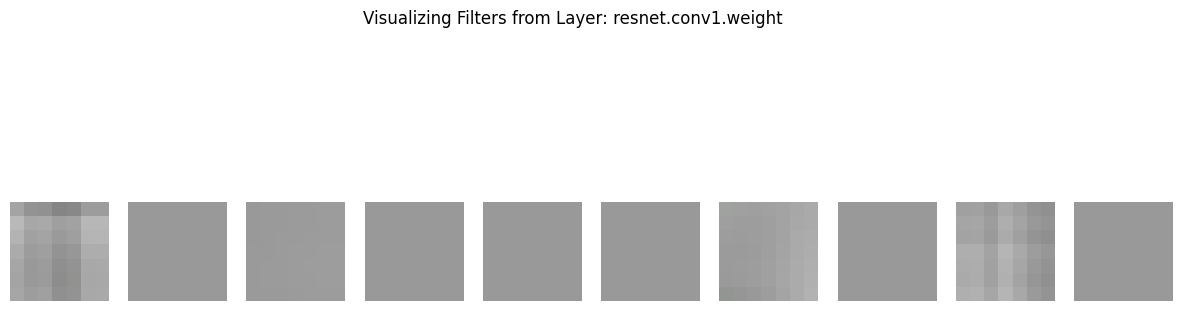

In [6]:
import matplotlib.pyplot as plt

def visualize_filters(model, num_filters=10):
    """Visualizes the filters of the model that have requires_grad set to True."""
    # Iterate over all layers in the model
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name:
            # Extract weights from the convolutional layers
            filters = param.data.clone()
            filters = filters - filters.min()  # Normalize to [0, 1]
            filters = filters / filters.max()

            # Number of filters to visualize
            num_filters = min(num_filters, filters.size(0))

            # Set up the figure
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f'Visualizing Filters from Layer: {name}')

            for i in range(num_filters):
                # Assuming filters are 3D tensors (out_channels, in_channels, height, width)
                if filters.dim() == 4:  # Convolutional filter
                    axes[i].imshow(filters[i].permute(1, 2, 0).cpu().numpy())  # Convert to (H, W, C)
                axes[i].axis('off')
            plt.show()
            break  # Stop after the first layer with trainable filters

# Example usage:
visualize_filters(loaded_model)

In [23]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 8435070


In [ ]:
# Define transformation for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),            # Convert to tensor (1 channel)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1 channel to 3 channels (RGB)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB
])

# Download the EMNIST ByClass dataset
test_dataset = EMNIST(root='data', split='byclass', train=False, download=True, transform=transform)
print(f'Test set size: {len(test_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=448)

Test set size: 116323


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.84
Precision (Micro): 0.84, Recall (Micro): 0.84, F1-Score (Micro): 0.84
Precision (Macro): 0.77, Recall (Macro): 0.70, F1-Score (Macro): 0.70


#### Setting 2

In [7]:
# Initialize the model (ensure the architecture matches)
loaded_model = ResNet18Classifier(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/resnet18_classifier_setting2.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-7-7888f639674c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/

ResNet18Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

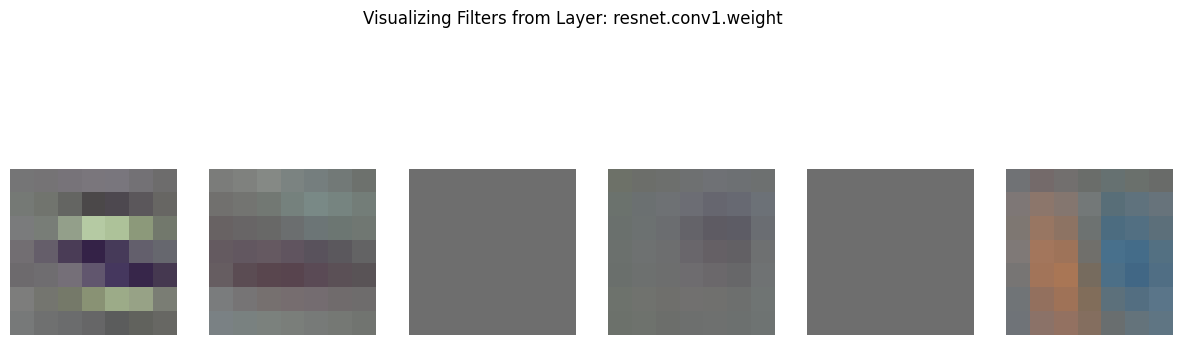

In [8]:
import matplotlib.pyplot as plt

def visualize_filters(model, num_filters=6):
    """Visualizes the filters of the model that have requires_grad set to True."""
    # Iterate over all layers in the model
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name:
            # Extract weights from the convolutional layers
            filters = param.data.clone()
            filters = filters - filters.min()  # Normalize to [0, 1]
            filters = filters / filters.max()

            # Number of filters to visualize
            num_filters = min(num_filters, filters.size(0))

            # Set up the figure
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f'Visualizing Filters from Layer: {name}')

            for i in range(num_filters):
                # Assuming filters are 3D tensors (out_channels, in_channels, height, width)
                if filters.dim() == 4:  # Convolutional filter
                    axes[i].imshow(filters[i].permute(1, 2, 0).cpu().numpy())  # Convert to (H, W, C)
                axes[i].axis('off')
            plt.show()
            break  # Stop after the first layer with trainable filters

# Example usage:
visualize_filters(loaded_model)

In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.88
Precision (Micro): 0.88, Recall (Micro): 0.88, F1-Score (Micro): 0.88
Precision (Macro): 0.82, Recall (Macro): 0.76, F1-Score (Macro): 0.76


#### Setting 3

In [9]:
# Initialize the model (ensure the architecture matches)
loaded_model = ResNet18Classifier(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/resnet18_classifier_setting3.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-9-9067be5695a2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/

ResNet18Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

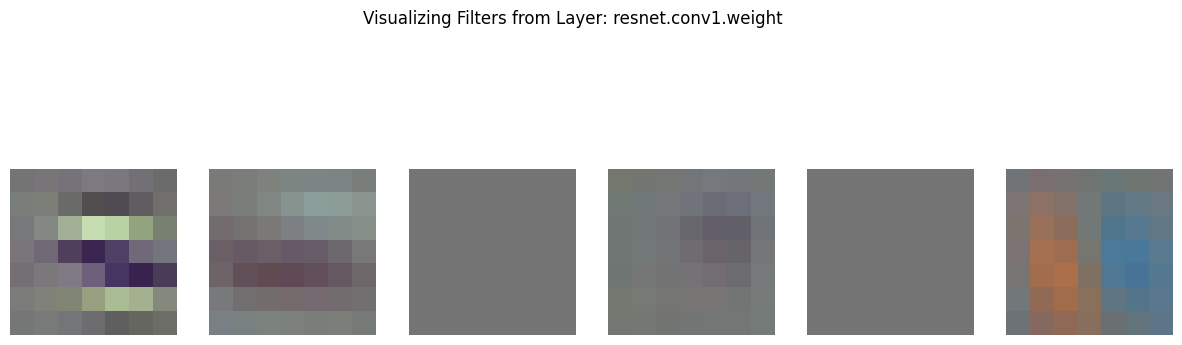

In [10]:
import matplotlib.pyplot as plt

def visualize_filters(model, num_filters=6):
    """Visualizes the filters of the model that have requires_grad set to True."""
    # Iterate over all layers in the model
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name:
            # Extract weights from the convolutional layers
            filters = param.data.clone()
            filters = filters - filters.min()  # Normalize to [0, 1]
            filters = filters / filters.max()

            # Number of filters to visualize
            num_filters = min(num_filters, filters.size(0))

            # Set up the figure
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f'Visualizing Filters from Layer: {name}')

            for i in range(num_filters):
                # Assuming filters are 3D tensors (out_channels, in_channels, height, width)
                if filters.dim() == 4:  # Convolutional filter
                    axes[i].imshow(filters[i].permute(1, 2, 0).cpu().numpy())  # Convert to (H, W, C)
                axes[i].axis('off')
            plt.show()
            break  # Stop after the first layer with trainable filters

# Example usage:
visualize_filters(loaded_model)

In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.84
Precision (Micro): 0.84, Recall (Micro): 0.84, F1-Score (Micro): 0.84
Precision (Macro): 0.78, Recall (Macro): 0.73, F1-Score (Macro): 0.72


#### Setting 4

In [18]:
# Initialize the model (ensure the architecture matches)
loaded_model = ResNet18Classifier(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/resnet18_classifier_setting4.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-18-b903a07cccac>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models

ResNet18Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

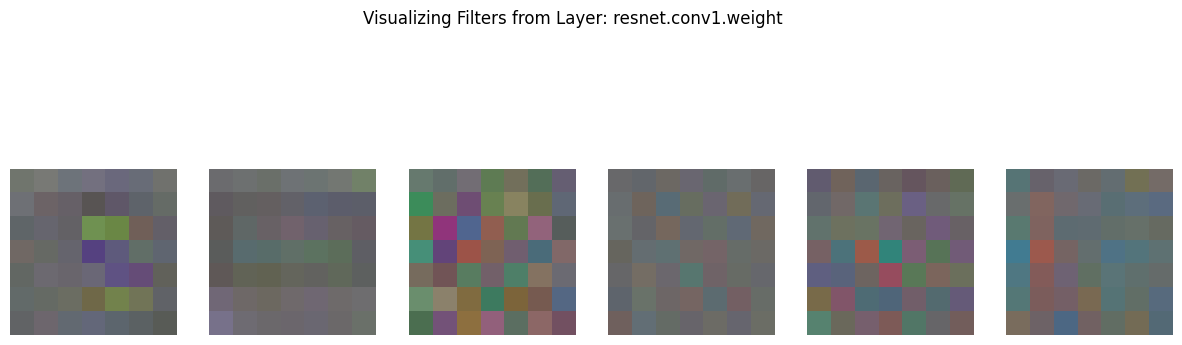

In [19]:
import matplotlib.pyplot as plt

def visualize_filters(model, num_filters=6):
    """Visualizes the filters of the model that have requires_grad set to True."""
    # Iterate over all layers in the model
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name:
            # Extract weights from the convolutional layers
            filters = param.data.clone()
            filters = filters - filters.min()  # Normalize to [0, 1]
            filters = filters / filters.max()

            # Number of filters to visualize
            num_filters = min(num_filters, filters.size(0))

            # Set up the figure
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f'Visualizing Filters from Layer: {name}')

            for i in range(num_filters):
                # Assuming filters are 3D tensors (out_channels, in_channels, height, width)
                if filters.dim() == 4:  # Convolutional filter
                    axes[i].imshow(filters[i].permute(1, 2, 0).cpu().numpy())  # Convert to (H, W, C)
                axes[i].axis('off')
            plt.show()
            break  # Stop after the first layer with trainable filters

# Example usage:
visualize_filters(loaded_model)

In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.79
Precision (Micro): 0.79, Recall (Micro): 0.79, F1-Score (Micro): 0.79
Precision (Macro): 0.72, Recall (Macro): 0.68, F1-Score (Macro): 0.64


#### Setting 6

In [16]:
# Initialize the model (ensure the architecture matches)
loaded_model = ResNet18Classifier(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/resnet18_classifier_setting6.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-16-281601083610>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models

ResNet18Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

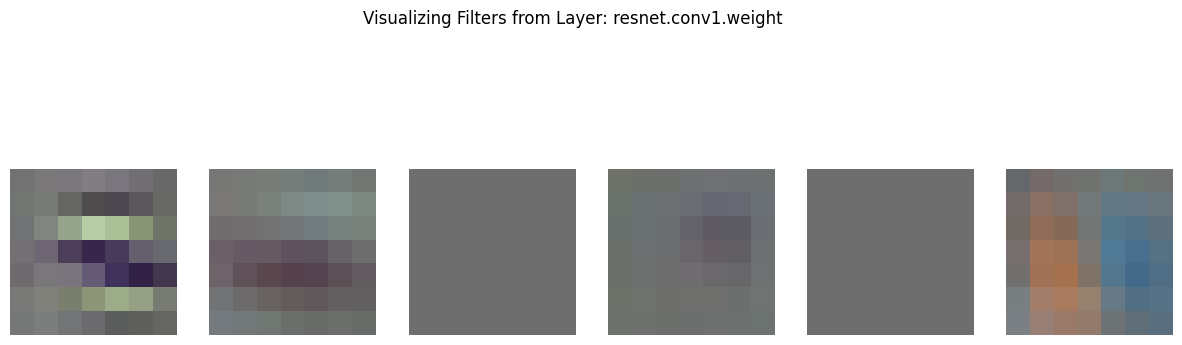

In [17]:
import matplotlib.pyplot as plt

def visualize_filters(model, num_filters=6):
    """Visualizes the filters of the model that have requires_grad set to True."""
    # Iterate over all layers in the model
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name:
            # Extract weights from the convolutional layers
            filters = param.data.clone()
            filters = filters - filters.min()  # Normalize to [0, 1]
            filters = filters / filters.max()

            # Number of filters to visualize
            num_filters = min(num_filters, filters.size(0))

            # Set up the figure
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f'Visualizing Filters from Layer: {name}')

            for i in range(num_filters):
                # Assuming filters are 3D tensors (out_channels, in_channels, height, width)
                if filters.dim() == 4:  # Convolutional filter
                    axes[i].imshow(filters[i].permute(1, 2, 0).cpu().numpy())  # Convert to (H, W, C)
                axes[i].axis('off')
            plt.show()
            break  # Stop after the first layer with trainable filters

# Example usage:
visualize_filters(loaded_model)

In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.83
Precision (Micro): 0.83, Recall (Micro): 0.83, F1-Score (Micro): 0.83
Precision (Macro): 0.73, Recall (Macro): 0.75, F1-Score (Macro): 0.72


## Custom Architectures

In [ ]:
# Define transformation for the images
transform = transforms.Compose([
    transforms.ToTensor(),            # Convert to tensor (1 channel)
    transforms.Normalize((0.5), (0.5))  # Normalize for RGB
])

# Download the EMNIST ByClass dataset
test_dataset = EMNIST(root='data', split='byclass', train=False, download=True, transform=transform)
print(f'Test set size: {len(test_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=2048)

Test set size: 116323


#### Arch1

##### Arch1.1

In [20]:
class Arch1(nn.Module):
    def __init__(self, num_classes=62):
        super(Arch1, self).__init__()  # Make sure you are calling the right parent class

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x8

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 7x7x16
        )

        self.classifier = nn.Linear(7 * 7 * 16, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [21]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch1(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model1.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-21-521afe795335>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models

Arch1(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=784, out_features=62, bias=True)
)

In [26]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 52822


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.82
Precision (Micro): 0.82, Recall (Micro): 0.82, F1-Score (Micro): 0.82
Precision (Macro): 0.73, Recall (Macro): 0.68, F1-Score (Macro): 0.69


##### Arch1.2

In [27]:
class Arch1(nn.Module):
    def __init__(self, num_classes=62):
        super(Arch1, self).__init__()

        # Modified VGG-style convolutional layers for 28x28x1 input
        self.features = nn.Sequential(
            # Conv Layer 1 (Input: 28x28x1, Output: 28x28x64)
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Conv Layer 2 (Output: 28x28x64)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x64

            # Conv Layer 3 (Output: 14x14x128)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Conv Layer 4 (Output: 14x14x128)
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 7x7x128
        )

        # Fully connected layer without hidden layers
        # Flatten the features from 7x7x128 to 6272 before feeding into the output layer
        self.classifier = nn.Linear(7 * 7 * 128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [28]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch1(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model1_heavy.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-28-3b0e0992b6b7>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Arch1(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=6272, out_features=62, bias=True)
)

In [29]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 647934


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.87
Precision (Micro): 0.87, Recall (Micro): 0.87, F1-Score (Micro): 0.87
Precision (Macro): 0.77, Recall (Macro): 0.75, F1-Score (Macro): 0.75


#### Arch2

##### Arch2.1

In [30]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNetMod(nn.Module):
    def __init__(self, block, num_blocks, num_classes=62):
        super(ResNetMod, self).__init__()
        self.in_planes = 16  # Reduced input channels

        # Adjust input conv layer for 28x28x1 input instead of 224x224x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # ResNet Layers with fewer blocks and planes
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)

        # Average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adapted to small input size
        self.fc = nn.Linear(32 * block.expansion, num_classes)  # Adjusted output size

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the modified ResNet model with reduced parameters
def Arch2(num_classes=62):
    return ResNetMod(BasicBlock, [1, 1], num_classes)  # Reduced blocks for further parameter reduction

In [31]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch2(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model2.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-31-4b7b8c7ed963>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



ResNetMod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, e

In [32]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 21422


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.84
Precision (Micro): 0.84, Recall (Micro): 0.84, F1-Score (Micro): 0.84
Precision (Macro): 0.75, Recall (Macro): 0.71, F1-Score (Macro): 0.70


##### Arch2.2

In [33]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNetMod(nn.Module):
    def __init__(self, block, num_blocks, num_classes=62):
        super(ResNetMod, self).__init__()
        self.in_planes = 32  # Reduced from 64 to 32

        # Adjust input conv layer for 28x28x1 input instead of 224x224x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)  # Reduced filters
        self.bn1 = nn.BatchNorm2d(32)

        # ResNet Layers with reduced planes
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)  # Reduced from 64 to 32 filters
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)  # Reduced from 128 to 64 filters

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adapted to small input size
        self.fc = nn.Linear(64 * block.expansion, num_classes)  # Reduced input size

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the modified ResNet model
def Arch2_2(num_classes=62):
    return ResNetMod(BasicBlock, [2, 2], num_classes)

In [34]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch2_2(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model2_2.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-34-be28a9d7fa81>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



ResNetMod(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [35]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 173214


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.87
Precision (Micro): 0.87, Recall (Micro): 0.87, F1-Score (Micro): 0.87
Precision (Macro): 0.82, Recall (Macro): 0.74, F1-Score (Macro): 0.74


#### Arch3

##### Arch3.1

In [36]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(torch.relu(self.bn1(x)))
        out = self.conv2(torch.relu(self.bn2(out)))
        out = torch.cat([x, out], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNetMod(nn.Module):
    def __init__(self, num_classes=62, growth_rate=24, block_layers=[6, 6]):
        super(DenseNetMod, self).__init__()
        self.growth_rate = growth_rate
        num_planes = 2 * growth_rate  # Starting number of planes

        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, num_planes, kernel_size=3, padding=1, bias=False)

        # Dense Block 1
        self.block1 = self._make_dense_layers(Bottleneck, num_planes, block_layers[0])
        num_planes += block_layers[0] * growth_rate
        self.trans1 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        # Dense Block 2
        self.block2 = self._make_dense_layers(Bottleneck, num_planes, block_layers[1])
        num_planes += block_layers[1] * growth_rate
        self.trans2 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        # Global average pooling and fully connected layer
        self.bn = nn.BatchNorm2d(num_planes)
        self.fc = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_channels, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.trans1(out)
        out = self.block2(out)
        out = self.trans2(out)
        out = torch.relu(self.bn(out))
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the modified ResNet model
def Arch3(num_classes=62):
    return DenseNetMod(num_classes=num_classes, growth_rate=12, block_layers=[4, 4])

In [37]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch3(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model3.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-37-cad3cd37c94d>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



DenseNetMod(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [38]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 70838


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.87
Precision (Micro): 0.87, Recall (Micro): 0.87, F1-Score (Micro): 0.87
Precision (Macro): 0.80, Recall (Macro): 0.73, F1-Score (Macro): 0.73


##### Arch3.2

In [39]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(torch.relu(self.bn1(x)))
        out = self.conv2(torch.relu(self.bn2(out)))
        out = torch.cat([x, out], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNetMod(nn.Module):
    def __init__(self, num_classes=62, growth_rate=24, block_layers=[6, 6]):
        super(DenseNetMod, self).__init__()
        self.growth_rate = growth_rate
        num_planes = 2 * growth_rate  # Starting number of planes

        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, num_planes, kernel_size=3, padding=1, bias=False)

        # Dense Block 1
        self.block1 = self._make_dense_layers(Bottleneck, num_planes, block_layers[0])
        num_planes += block_layers[0] * growth_rate
        self.trans1 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        # Dense Block 2
        self.block2 = self._make_dense_layers(Bottleneck, num_planes, block_layers[1])
        num_planes += block_layers[1] * growth_rate
        self.trans2 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        # Global average pooling and fully connected layer
        self.bn = nn.BatchNorm2d(num_planes)
        self.fc = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_channels, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.trans1(out)
        out = self.block2(out)
        out = self.trans2(out)
        out = torch.relu(self.bn(out))
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the modified ResNet model
def Arch3_heavy(num_classes):
    return DenseNetMod(num_classes=num_classes, growth_rate=24, block_layers=[6, 6])

In [40]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch3_heavy(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model3_2.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-40-b8a9bd9fd2dc>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



DenseNetMod(
  (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(72, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [41]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 462638


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.88
Precision (Micro): 0.88, Recall (Micro): 0.88, F1-Score (Micro): 0.88
Precision (Macro): 0.81, Recall (Macro): 0.76, F1-Score (Macro): 0.77


##### Arch3.2_Blsmote

In [42]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(torch.relu(self.bn1(x)))
        out = self.conv2(torch.relu(self.bn2(out)))
        out = torch.cat([x, out], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNetMod(nn.Module):
    def __init__(self, num_classes=62, growth_rate=24, block_layers=[6, 6]):
        super(DenseNetMod, self).__init__()
        self.growth_rate = growth_rate
        num_planes = 2 * growth_rate  # Starting number of planes

        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, num_planes, kernel_size=3, padding=1, bias=False)

        # Dense Block 1
        self.block1 = self._make_dense_layers(Bottleneck, num_planes, block_layers[0])
        num_planes += block_layers[0] * growth_rate
        self.trans1 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        # Dense Block 2
        self.block2 = self._make_dense_layers(Bottleneck, num_planes, block_layers[1])
        num_planes += block_layers[1] * growth_rate
        self.trans2 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        # Global average pooling and fully connected layer
        self.bn = nn.BatchNorm2d(num_planes)
        self.fc = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_channels, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.trans1(out)
        out = self.block2(out)
        out = self.trans2(out)
        out = torch.relu(self.bn(out))
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def Arch3_heavy(num_classes):
    return DenseNetMod(num_classes=num_classes, growth_rate=12, block_layers=[6, 6])

In [43]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch3_heavy(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model3_2_blsmote.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-43-d0172841e3f6>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



DenseNetMod(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [44]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 119318


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.85
Precision (Micro): 0.85, Recall (Micro): 0.85, F1-Score (Micro): 0.85
Precision (Macro): 0.82, Recall (Macro): 0.69, F1-Score (Macro): 0.66


#### Arch4

In [45]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = torch.relu(self.bn1(self.depthwise(x)))
        out = self.bn2(self.pointwise(out))
        return out

class Arch4(nn.Module):
    def __init__(self, num_classes=62):
        super(Arch4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.dw_conv1 = DepthwiseSeparableConv(32, 64)
        self.dw_conv2 = DepthwiseSeparableConv(64, 128, stride=2)
        self.dw_conv3 = DepthwiseSeparableConv(128, 128)
        self.dw_conv4 = DepthwiseSeparableConv(128, 256, stride=2)
        self.dw_conv5 = DepthwiseSeparableConv(256, 256)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.dw_conv1(out)
        out = self.dw_conv2(out)
        out = self.dw_conv3(out)
        out = self.dw_conv4(out)
        out = self.dw_conv5(out)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [46]:
# Initialize the model (ensure the architecture matches)
loaded_model = Arch4(num_classes=62)

# Load the state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/data/Assignment_DL4CV_models/model4.pth'))

# Move the model to the appropriate device (e.g., GPU if available)
loaded_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode if you're using it for inference
loaded_model.eval()

<ipython-input-46-d6a938e80fd0>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Arch4(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dw_conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dw_conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [47]:
num_params_expanded = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print(f'Total number of parameters: {num_params_expanded}')

Total number of parameters: 149566


In [ ]:
criterion = nn.CrossEntropyLoss
classifier = ImageClassifier(loaded_model, criterion)
classifier.test(test_loader)

Accuracy: 0.87
Precision (Micro): 0.87, Recall (Micro): 0.87, F1-Score (Micro): 0.87
Precision (Macro): 0.80, Recall (Macro): 0.75, F1-Score (Macro): 0.75
